# Titanic Dataset - k-Nearest Neighbor without Ticket Feature & Cabin

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.style.use('ggplot')

import seaborn as sns

In [2]:
# ReadIn the training data
titanic_train = pd.read_csv("titanic_train.csv")
print (titanic_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


## Variable Notes

>pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

>age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

>sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancÃ©s were ignored)

>parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [3]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Separate out the target/ label from the dataset

In [5]:
print(f'All column names: {titanic_train.columns}')
X_train = titanic_train.copy()
y_train = X_train.pop('Survived')
print(f'Training data column names: {X_train.columns}')
print(f'Training label: {y_train.name}')

All column names: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Training data column names: Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Training label: Survived


## Helper Functions

In [6]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    # print (big_string)
    return np.nan

def replace_titles(x):
    title=x['salut']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

## Data Preprocessing - Training Data

In [7]:
# Split Name and extract the salutation

X_train['salut'] = X_train['Name'].str.split(',',expand=True)[1].str.split('.',expand=True)[0].str.strip()
print("Unique values from salut - training dataset:\n", X_train['salut'].unique(), "\n")

print ("salut Before:")
print (X_train['salut'].value_counts(), "\n")

# X_train.drop(['firstname', 'last_name', 'lastname', 'lastname1'], axis=1, inplace=True)
print (X_train.columns, "\n")

X_train['salut']=X_train.apply(replace_titles, axis=1)
print ("salut After:")
print (X_train['salut'].value_counts())

Age_salut = pd.crosstab(X_train.Age, X_train.salut)
Age_salut.tail(10)

Unique values from salut - training dataset:
 ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer'] 

salut Before:
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Lady              1
Don               1
Mme               1
Capt              1
Jonkheer          1
Sir               1
Ms                1
Name: salut, dtype: int64 

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'salut'],
      dtype='object') 

salut After:
Mr        531
Miss      185
Mrs       135
Master     40
Name: salut, dtype: int64


salut,Master,Miss,Mr,Mrs
Age,,,,
62.0,0,0,3,1
63.0,0,1,0,1
64.0,0,0,2,0
65.0,0,0,3,0
66.0,0,0,1,0
70.0,0,0,2,0
70.5,0,0,1,0
71.0,0,0,2,0
74.0,0,0,1,0


## Imputing data to fill in the missing values

In [8]:
# Imputing Age - We are using the 'salut' feature to group the respondent to impute the age
print ("Null values for Age before imputation: ", X_train['Age'].isnull().sum())
X_train['Age'] = X_train.groupby('salut').Age.transform(lambda x: x.fillna(x.mean()))
print ("Null values for Age after imputation: ", X_train['Age'].isnull().sum())

Null values for Age before imputation:  177
Null values for Age after imputation:  0


In [9]:
# Imputing Cabin - This cannot be imputed as there is no logic and hence we fill the NAs with 'Null' string
print("Null values for Cabin before imputation: ", X_train['Cabin'].isnull().sum())

print("Value Counts of Cabin - Before")
print (X_train['Cabin'].value_counts(dropna = False))

X_train['Cabin'] = X_train['Cabin'].fillna('Null')

print("Value Counts of Cabin - After")
print (X_train['Cabin'].value_counts(dropna = False))

Null values for Cabin before imputation:  687
Value Counts of Cabin - Before
NaN            687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
A24              1
C62 C64          1
D45              1
C82              1
C104             1
Name: Cabin, Length: 148, dtype: int64
Value Counts of Cabin - After
Null           687
B96 B98          4
C23 C25 C27      4
G6               4
E101             3
              ... 
E50              1
B19              1
B37              1
D47              1
C87              1
Name: Cabin, Length: 148, dtype: int64


In [10]:
# Imputing the whole dataset just in case there are any furhter missing values
X_train = X_train.fillna(method='ffill').fillna(method='bfill')
print("Null values after imputation: ")
print(X_train.isnull().sum())

Null values after imputation: 
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
salut          0
dtype: int64


## Feature Engineering

In [11]:
# Deck
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Null']
X_train['Deck']=X_train['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))

X_train['Deck'].value_counts()

Null    687
C        59
B        47
D        33
E        33
A        15
F        12
G         4
T         1
Name: Deck, dtype: int64

In [12]:
# Family Size and Fare per Passenger
X_train['FamilySize'] = X_train['SibSp'] + X_train['Parch'] + 1
# X_train['FarePerPassenger'] = X_train['Fare']/(X_train['FamilySize'])

print(X_train['FamilySize'].value_counts())
# print()
# print(X_train['FarePerPassenger'].value_counts())

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64


In [13]:
# X_train.to_csv("Titanic_Train_Processed.csv", index = False)

## Converting Categorical and String features into Numeric

In [14]:
# Drop features which are unique across respondents as they are not useful
X_train.drop(['Name', 'PassengerId', 'Cabin', 'Ticket'], axis=1, inplace=True)

# One Hot Encoding - To convert categorical to binary data
X_train_dummies = pd.get_dummies(X_train, columns=['Pclass', 'Sex', 'Embarked', 'salut', 'Deck'])

print ("Shape of training dataset after One Hot Encoding: ", X_train_dummies.shape)
print (X_train_dummies.head())

Shape of training dataset after One Hot Encoding:  (891, 26)
    Age  SibSp  Parch     Fare  FamilySize  Pclass_1  Pclass_2  Pclass_3  \
0  22.0      1      0   7.2500           2         0         0         1   
1  38.0      1      0  71.2833           2         1         0         0   
2  26.0      0      0   7.9250           1         0         0         1   
3  35.0      1      0  53.1000           2         1         0         0   
4  35.0      0      0   8.0500           1         0         0         1   

   Sex_female  Sex_male  ...  salut_Mrs  Deck_A  Deck_B  Deck_C  Deck_D  \
0           0         1  ...          0       0       0       0       0   
1           1         0  ...          1       0       0       1       0   
2           1         0  ...          0       0       0       0       0   
3           1         0  ...          1       0       0       1       0   
4           0         1  ...          0       0       0       0       0   

   Deck_E  Deck_F  Deck_G  Deck

## Test Data - ReadIn, Preprocess, Imputing, Feature Engineering and One Hot Encoding

In [15]:
# ReadIn the test data

titanic_test = pd.read_csv("titanic_test.csv")

In [16]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [17]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [18]:
titanic_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [19]:
X_test = titanic_test.copy()

# Split Name and extract the salutation
X_test['salut'] = X_test['Name'].str.split(',',expand=True)[1].str.split('.',expand=True)[0].str.strip()
print("Unique values from salut - test dataset:\n", X_test['salut'].unique())

print ("salut Before:")
print (X_test['salut'].value_counts())

print (X_test.columns)

X_test['salut']=X_test.apply(replace_titles, axis=1)

print ("salut After:")
print (X_test['salut'].value_counts())

Age_salut_test = pd.crosstab(X_test.Age, X_test.salut)
print(Age_salut_test.head(6))
print(Age_salut_test.tail(6))

Unique values from salut - test dataset:
 ['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']
salut Before:
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: salut, dtype: int64
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'salut'],
      dtype='object')
salut After:
Mr        244
Miss       79
Mrs        74
Master     21
Name: salut, dtype: int64
salut  Master  Miss  Mr  Mrs
Age                         
0.17        0     1   0    0
0.33        1     0   0    0
0.75        1     0   0    0
0.83        1     0   0    0
0.92        0     1   0    0
1.00        0     3   0    0
salut  Master  Miss  Mr  Mrs
Age                         
61.0        0     0   2    0
62.0        0     0   1    0
63.0        0     0   1    1
64.0        0     0   1    2
67.0        0     0   1    0
76.0        0     0   0    1


In [20]:
# Imputing missing values - Test Data
print ("Null values for Age before imputation: ", X_test['Age'].isnull().sum())
X_test['Age'] = X_test.groupby('salut').Age.transform(lambda x: x.fillna(x.mean()))
print ("Null values for Age after imputation: ", X_test['Age'].isnull().sum(), "\n")

print ("Null values for Fare before imputation: ", X_test['Fare'].isnull().sum())
X_test['Fare'] = X_test.groupby('Pclass').Fare.transform(lambda x: x.fillna(x.median()))
print ("Null values for Fare after imputation: ", X_test['Fare'].isnull().sum(), "\n")

print("Null values for Cabin before imputation: ", X_test['Cabin'].isnull().sum())
X_test['Cabin'] = X_test['Cabin'].fillna('Null')
print("Null values for Cabin after imputation: ", X_test['Cabin'].isnull().sum(), "\n")

# Imputing the whole dataset just in case there are any furhter missing values
X_test = X_test.fillna(method='ffill').fillna(method='bfill')

print("Null values after imputation: ")
print(X_test.isnull().sum())

Null values for Age before imputation:  86
Null values for Age after imputation:  0 

Null values for Fare before imputation:  1
Null values for Fare after imputation:  0 

Null values for Cabin before imputation:  327
Null values for Cabin after imputation:  0 

Null values after imputation: 
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
salut          0
dtype: int64


In [21]:
## Feature Engineering
# Deck
X_test['Deck']=X_test['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
print(X_test['Deck'].value_counts(), "\n")

# Family Size and Fare per Passenger
X_test['FamilySize'] = X_test['SibSp'] + X_test['Parch'] + 1
# X_test['FarePerPassenger'] = X_test['Fare']/(X_test['FamilySize'] + 1)

print(X_test['FamilySize'].value_counts(), "\n")
# print()
# print(X_test['FarePerPassenger'].value_counts(), "\n")

Null    327
C        35
B        18
D        13
E        11
A         7
F         6
G         1
Name: Deck, dtype: int64 

1     253
2      74
3      57
4      14
5       7
11      4
7       4
6       3
8       2
Name: FamilySize, dtype: int64 



In [22]:
## Converting Categorical and String features into Numeric

# Drop features which are unique across respondents as they are not useful
X_test.drop(['PassengerId', 'Cabin', 'Ticket'], axis=1, inplace=True)

# One Hot Encoding - To convert categorical to binary data
X_test_dummies = pd.get_dummies(X_test, columns=['Pclass', 'Sex', 'Embarked', 'salut', 'Deck'])
print ("Shape of test dataset after One Hot Encoding: ", X_test_dummies.shape)
print (X_test_dummies.head())

Shape of test dataset after One Hot Encoding:  (418, 26)
                                           Name   Age  SibSp  Parch     Fare  \
0                              Kelly, Mr. James  34.5      0      0   7.8292   
1              Wilkes, Mrs. James (Ellen Needs)  47.0      1      0   7.0000   
2                     Myles, Mr. Thomas Francis  62.0      0      0   9.6875   
3                              Wirz, Mr. Albert  27.0      0      0   8.6625   
4  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  22.0      1      1  12.2875   

   FamilySize  Pclass_1  Pclass_2  Pclass_3  Sex_female  ...  salut_Mr  \
0           1         0         0         1           0  ...         1   
1           2         0         0         1           1  ...         0   
2           1         0         1         0           0  ...         1   
3           1         0         0         1           0  ...         1   
4           3         0         0         1           1  ...         0   

   salut_Mrs  Dec

In [23]:
print ("Shape of training dataset after One Hot Encoding: ", X_train_dummies.shape)
print ("Shape of test dataset after One Hot Encoding: ", X_test_dummies.shape)

Shape of training dataset after One Hot Encoding:  (891, 26)
Shape of test dataset after One Hot Encoding:  (418, 26)


In [24]:
# Align the Train and Test datset for One Hot Encoding 
X_train_final, X_test_final = X_train_dummies.align(X_test_dummies, join='left', axis=1)
print (X_train_final.shape)
print (X_test_final.shape)

for col in (col for col in X_test_final.columns if X_test_final[col].isnull().any()):
    X_test_final[col] = 0

print(X_test_final.isnull().sum())

(891, 26)
(418, 26)
Age             0
SibSp           0
Parch           0
Fare            0
FamilySize      0
Pclass_1        0
Pclass_2        0
Pclass_3        0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
salut_Master    0
salut_Miss      0
salut_Mr        0
salut_Mrs       0
Deck_A          0
Deck_B          0
Deck_C          0
Deck_D          0
Deck_E          0
Deck_F          0
Deck_G          0
Deck_Null       0
Deck_T          0
dtype: int64


## Model Training

### Scaling the data

In [25]:
X_train_final_description = X_train_final.describe().T
X_test_final_description = X_test_final.describe().T

X_train_final_description.to_csv("X_train_final_description.csv")
X_test_final_description.to_csv("X_test_final_description.csv")

In [26]:
print(X_train_final['Parch'].value_counts(dropna=False))

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


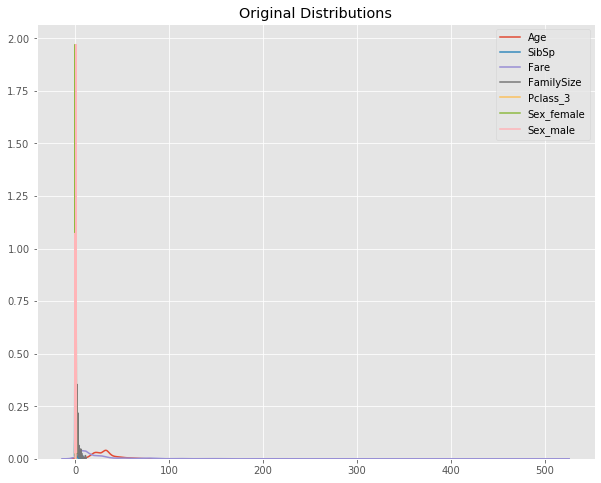

In [27]:
# plot original distribution plot
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Original Distributions')

column_list = ['Age', 'SibSp', 'Fare', 'FamilySize', 'Pclass_3', 'Sex_female', 'Sex_male']

X_train_final[column_list].apply(sns.kdeplot, ax = ax1);

In [28]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_final)
# print(X_train_scaled.mean(axis=0))
X_test_scaled = scaler.transform(X_test_final)

df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_final.columns)
df_X_train_scaled.describe().T.to_csv('X_train_MinMaxScaled_description.csv')

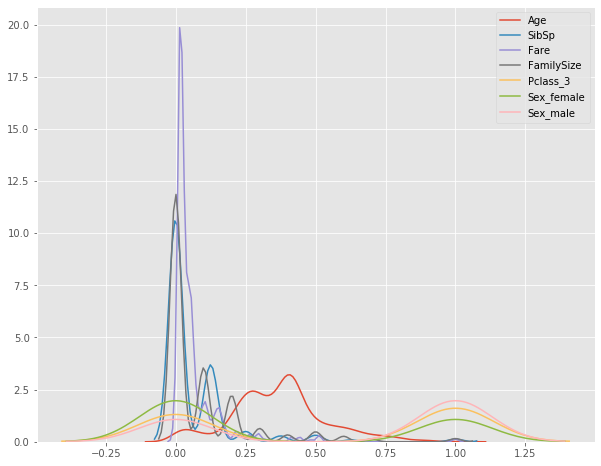

In [29]:
# plot original distribution plot
fig, (ax2) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Scaled Distributions')

# print([*df_X_train_scaled.columns])
# column_list = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_Null', 'Deck_T']

column_list = ['Age', 'SibSp', 'Fare', 'FamilySize', 'Pclass_3', 'Sex_female', 'Sex_male']

df_X_train_scaled[column_list].apply(sns.kdeplot, ax = ax2);

In [30]:
# split the data into train and evaluation data
from sklearn.model_selection import train_test_split

# X, val_X, y, val_y = train_test_split(X_train_final, y_train, train_size=0.7, test_size=0.3, random_state=123, stratify=y_train)

# Applying scaled data
X, val_X, y, val_y = train_test_split(X_train_scaled, y_train, train_size=0.7, test_size=0.3, random_state=123, stratify=y_train)

print (X.shape)
print (val_X.shape)
print('All:', np.bincount(y_train) / float(len(y_train)) * 100.0)
print('Training:', np.bincount(y) / float(len(y)) * 100.0)
print('Test:', np.bincount(val_y) / float(len(val_y)) * 100.0)
type(X), type(y)

(623, 26)
(268, 26)
All: [61.61616162 38.38383838]
Training: [61.63723917 38.36276083]
Test: [61.56716418 38.43283582]


(numpy.ndarray, pandas.core.series.Series)

## k-Nearest Neighbors

In [31]:
from sklearn.neighbors import KNeighborsClassifier

model_knearest_neighbors = KNeighborsClassifier(n_neighbors = 5)
model_knearest_neighbors.fit(X,y)

print("Model Parameters:")
print(model_knearest_neighbors.get_params(), "\n")

predictions = model_knearest_neighbors.predict(val_X)
predict_proba = model_knearest_neighbors.predict_proba(val_X)

print ("Count for validation data - actual: ", np.bincount(val_y))
print ("Count for validation data - prediction: ", np.bincount(predictions), "\n")

Model Parameters:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'} 

Count for validation data - actual:  [165 103]
Count for validation data - prediction:  [184  84] 



### Model Evaluation

In [32]:
# Score
print ("Score for training data - k-Nearest Neighbor: ", model_knearest_neighbors.score(X, y))
score_val_dataset = model_knearest_neighbors.score(val_X, val_y)
print ("Score for validation data - k-Nearest Neighbor: ", score_val_dataset, "\n")

print("Predictions: ", predictions[0:6], "\n")
print("Prediction Probabilities:\n", predict_proba[0:6])

Score for training data - k-Nearest Neighbor:  0.8667736757624398
Score for validation data - k-Nearest Neighbor:  0.8395522388059702 

Predictions:  [0 1 0 0 0 0] 

Prediction Probabilities:
 [[0.8 0.2]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [0.8 0.2]
 [0.6 0.4]]


In [33]:
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score

print ("f1_score for validation data - k-Nearest Neighbor: ", f1_score(val_y, model_knearest_neighbors.predict(val_X)))
print ("f1_score (average=None) for validation data - k-Nearest Neighbor: ", f1_score(val_y, model_knearest_neighbors.predict(val_X), average=None), "\n")

print ("precision_recall_fscore for validation data - k-Nearest Neighbor: ", precision_recall_fscore_support(val_y, model_knearest_neighbors.predict(val_X)), "\n")

print("Accuracy for model k-Nearest Neighbor: %.2f" % (accuracy_score(val_y, model_knearest_neighbors.predict(val_X)) * 100))

f1_score for validation data - k-Nearest Neighbor:  0.7700534759358288
f1_score (average=None) for validation data - k-Nearest Neighbor:  [0.87679083 0.77005348] 

precision_recall_fscore for validation data - k-Nearest Neighbor:  (array([0.83152174, 0.85714286]), array([0.92727273, 0.69902913]), array([0.87679083, 0.77005348]), array([165, 103], dtype=int64)) 

Accuracy for model k-Nearest Neighbor: 83.96


### Model Selection

In [34]:
# Applying cross validation on the enire training data
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, ShuffleSplit

scores = cross_val_score(model_knearest_neighbors, X_train_scaled, y_train)
print("\nScore for training data with default CV: ", scores)
print(np.mean(scores))

scores = cross_val_score(model_knearest_neighbors, X_train_scaled, y_train, cv=3)
print("\nScore for training data with CV=3: ", scores)
print(np.mean(scores))


Score for training data with default CV:  [0.7877095  0.78651685 0.84831461 0.79775281 0.88202247]
0.8204632477559475

Score for training data with CV=3:  [0.78451178 0.83838384 0.83501684]
0.8193041526374859


In [35]:
# Applying cross validation by splitting the training data into training data and validation data
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, ShuffleSplit

scores = cross_val_score(model_knearest_neighbors, X, y)
print("Score for training data with default CV: ", scores)
print("Mean Score: ", np.mean(scores), "\n")

scores = cross_val_score(model_knearest_neighbors, X, y, cv=3)
print("Score for training data with CV=3: ", scores)
print("Mean Score: ", np.mean(scores), "\n")

scores = cross_val_score(model_knearest_neighbors, val_X, val_y, cv=3)
print("Score for validation data with CV=3: ", scores)
print("Mean Score: ", np.mean(scores))

Score for training data with default CV:  [0.864      0.792      0.768      0.82258065 0.80645161]
Mean Score:  0.8106064516129032 

Score for training data with CV=3:  [0.80288462 0.80288462 0.79710145]
Mean Score:  0.8009568933481978 

Score for validation data with CV=3:  [0.78888889 0.80898876 0.73033708]
Mean Score:  0.7760715771951728


In [36]:
cv = StratifiedKFold(n_splits=4)
scores = cross_val_score(model_knearest_neighbors, val_X, val_y, cv=cv)
print("Score for validation data with StartifiedKFold, CV=5: ", scores)
print("Mean Score: ", np.mean(scores))

Score for validation data with StartifiedKFold, CV=5:  [0.82089552 0.71641791 0.82089552 0.73134328]
Mean Score:  0.7723880597014926


### GridSearch

In [37]:
from sklearn.model_selection import GridSearchCV
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
param_grid = {'n_neighbors': [1, 5, 10, 15], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

model_knearest_neighbors_grid = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid=param_grid, cv=cv, verbose=3)
model_knearest_neighbors_grid.fit(X, y)

results_grid = model_knearest_neighbors_grid.cv_results_

print ("Parameters: ", model_knearest_neighbors_grid.get_params)

print("\nGridSearchCV best score - k-Nearest Neighbor: ", model_knearest_neighbors_grid.best_score_)
print("\nGridSearchCV best params - k-Nearest Neighbor: ", model_knearest_neighbors_grid.best_params_)
print("\nGridSearchCV best estimator - k-Nearest Neighbor: ", model_knearest_neighbors_grid.best_estimator_)

print ("\nGridSearchCV Score for validation data - k-Nearest Neighbor: ", model_knearest_neighbors_grid.score(val_X, val_y))

Fitting 4 folds for each of 32 candidates, totalling 128 fits
[CV] algorithm=auto, n_neighbors=1, weights=uniform ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  algorithm=auto, n_neighbors=1, weights=uniform, score=0.776, total=   6.4s
[CV] algorithm=auto, n_neighbors=1, weights=uniform ..................
[CV]  algorithm=auto, n_neighbors=1, weights=uniform, score=0.763, total=   0.0s
[CV] algorithm=auto, n_neighbors=1, weights=uniform ..................
[CV]  algorithm=auto, n_neighbors=1, weights=uniform, score=0.756, total=   0.0s
[CV] algorithm=auto, n_neighbors=1, weights=uniform ..................
[CV]  algorithm=auto, n_neighbors=1, weights=uniform, score=0.781, total=   0.0s
[CV] algorithm=auto, n_neighbors=1, weights=distance .................
[CV]  algorithm=auto, n_neighbors=1, weights=distance, score=0.776, total=   0.0s
[CV] algorithm=auto, n_neighbors=1, weights=distance .................
[CV]  algorithm=auto, n_neighbors=1, weights=distance, score=0.763, total=   0.0s
[CV] algorithm=auto, n_neighbors=1, weights=distance .................
[CV]  algorithm=auto, n_neighbors=1, weights=distance, score=0.756, total=   0.0s
[CV]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s



[CV] algorithm=auto, n_neighbors=5, weights=uniform ..................
[CV]  algorithm=auto, n_neighbors=5, weights=uniform, score=0.768, total=   0.0s
[CV] algorithm=auto, n_neighbors=5, weights=distance .................
[CV]  algorithm=auto, n_neighbors=5, weights=distance, score=0.801, total=   0.0s
[CV] algorithm=auto, n_neighbors=5, weights=distance .................
[CV]  algorithm=auto, n_neighbors=5, weights=distance, score=0.769, total=   0.0s
[CV] algorithm=auto, n_neighbors=5, weights=distance .................
[CV]  algorithm=auto, n_neighbors=5, weights=distance, score=0.769, total=   0.0s
[CV] algorithm=auto, n_neighbors=5, weights=distance .................
[CV]  algorithm=auto, n_neighbors=5, weights=distance, score=0.761, total=   0.0s
[CV] algorithm=auto, n_neighbors=10, weights=uniform .................
[CV]  algorithm=auto, n_neighbors=10, weights=uniform, score=0.865, total=   0.0s
[CV] algorithm=auto, n_neighbors=10, weights=uniform .................
[CV]  algor

[CV]  algorithm=kd_tree, n_neighbors=1, weights=distance, score=0.781, total=   0.0s
[CV] algorithm=kd_tree, n_neighbors=5, weights=uniform ...............
[CV]  algorithm=kd_tree, n_neighbors=5, weights=uniform, score=0.859, total=   0.0s
[CV] algorithm=kd_tree, n_neighbors=5, weights=uniform ...............
[CV]  algorithm=kd_tree, n_neighbors=5, weights=uniform, score=0.776, total=   0.0s
[CV] algorithm=kd_tree, n_neighbors=5, weights=uniform ...............
[CV]  algorithm=kd_tree, n_neighbors=5, weights=uniform, score=0.795, total=   0.0s
[CV] algorithm=kd_tree, n_neighbors=5, weights=uniform ...............
[CV]  algorithm=kd_tree, n_neighbors=5, weights=uniform, score=0.768, total=   0.0s
[CV] algorithm=kd_tree, n_neighbors=5, weights=distance ..............
[CV]  algorithm=kd_tree, n_neighbors=5, weights=distance, score=0.801, total=   0.0s
[CV] algorithm=kd_tree, n_neighbors=5, weights=distance ..............
[CV]  algorithm=kd_tree, n_neighbors=5, weights=distance, score=0.76

[CV]  algorithm=brute, n_neighbors=15, weights=distance, score=0.846, total=   0.1s
[CV] algorithm=brute, n_neighbors=15, weights=distance ...............
[CV]  algorithm=brute, n_neighbors=15, weights=distance, score=0.788, total=   0.1s
[CV] algorithm=brute, n_neighbors=15, weights=distance ...............
[CV]  algorithm=brute, n_neighbors=15, weights=distance, score=0.795, total=   0.1s
[CV] algorithm=brute, n_neighbors=15, weights=distance ...............
[CV]  algorithm=brute, n_neighbors=15, weights=distance, score=0.800, total=   0.1s
Parameters:  <bound method BaseEstimator.get_params of GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
        

[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:   11.7s finished


In [38]:
results_grid

{'mean_fit_time': array([0.00400603, 0.0034942 , 0.00299048, 0.00423938, 0.00523478,
        0.00423849, 0.00448811, 0.00249195, 0.00224435, 0.00249892,
        0.00224471, 0.00224465, 0.00199461, 0.00323969, 0.00224376,
        0.00323856, 0.00448692, 0.00373882, 0.00348973, 0.00299889,
        0.00375688, 0.00299942, 0.00324845, 0.00323951, 0.00149626,
        0.00124681, 0.00124663, 0.00124705, 0.00174588, 0.00149637,
        0.00124693, 0.00124729]),
 'std_fit_time': array([1.21546721e-03, 8.71365590e-04, 7.06044771e-04, 1.08796392e-03,
        4.30675674e-04, 8.27514680e-04, 4.99963831e-04, 4.98652472e-04,
        4.32155839e-04, 1.10298546e-03, 8.27766937e-04, 4.31433962e-04,
        6.07850494e-07, 8.28970418e-04, 4.32086597e-04, 4.28576628e-04,
        4.98175650e-04, 8.27029675e-04, 8.64586229e-04, 1.72605625e-05,
        8.35024825e-04, 1.16855510e-05, 8.23821910e-04, 4.31192392e-04,
        4.98354499e-04, 4.32017903e-04, 4.31571229e-04, 4.32018298e-04,
        4.32053456e-0

In [39]:
print("Model Parameters:")
print(model_knearest_neighbors_grid.get_params(), "\n")

predictions_grid = model_knearest_neighbors_grid.predict(val_X)
predict_proba_grid = model_knearest_neighbors_grid.predict_proba(val_X)

print ("Count for validation data - actual: ", np.bincount(val_y))
print ("Count for validation data - prediction-grid: ", np.bincount(predictions_grid), "\n")

Model Parameters:
{'cv': StratifiedKFold(n_splits=4, random_state=None, shuffle=False), 'error_score': nan, 'estimator__algorithm': 'auto', 'estimator__leaf_size': 30, 'estimator__metric': 'minkowski', 'estimator__metric_params': None, 'estimator__n_jobs': -1, 'estimator__n_neighbors': 5, 'estimator__p': 2, 'estimator__weights': 'uniform', 'estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform'), 'iid': 'deprecated', 'n_jobs': None, 'param_grid': {'n_neighbors': [1, 5, 10, 15], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 3} 

Count for validation data - actual:  [165 103]
Count for validation data - prediction-grid:  [193  75] 



In [40]:
# Score
print ("Score for training data - Logistic Regression: ", model_knearest_neighbors_grid.score(X, y))
score_grid_val_dataset = model_knearest_neighbors_grid.score(val_X, val_y)
print ("Score for validation data - Logistic Regression: ", score_grid_val_dataset, "\n")

print("Predictions grid: ", predictions_grid[0:6], "\n")
print("Prediction Probabilities grid:\n", predict_proba_grid[0:6])

Score for training data - Logistic Regression:  0.8314606741573034
Score for validation data - Logistic Regression:  0.8283582089552238 

Predictions grid:  [0 1 0 0 0 0] 

Prediction Probabilities grid:
 [[0.8 0.2]
 [0.  1. ]
 [0.9 0.1]
 [1.  0. ]
 [0.9 0.1]
 [0.6 0.4]]


### GridSearch with Scoring

In [41]:
scoring = {'Accuracy': 'accuracy', 'F1 Score': 'f1'}
model_knearest_neighbors_grid_with_scoring = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid=param_grid, cv=cv, verbose=3, scoring = scoring, refit=False)
model_knearest_neighbors_grid_with_scoring.fit(X, y)
results_grid_with_scoring = model_knearest_neighbors_grid_with_scoring.cv_results_

Fitting 4 folds for each of 32 candidates, totalling 128 fits
[CV] algorithm=auto, n_neighbors=1, weights=uniform ..................
[CV]  algorithm=auto, n_neighbors=1, weights=uniform, Accuracy=0.776, F1 Score=0.711, total=   0.0s
[CV] algorithm=auto, n_neighbors=1, weights=uniform ..................
[CV]  algorithm=auto, n_neighbors=1, weights=uniform, Accuracy=0.763, F1 Score=0.634, total=   0.0s
[CV] algorithm=auto, n_neighbors=1, weights=uniform ..................
[CV]  algorithm=auto, n_neighbors=1, weights=uniform, Accuracy=0.756, F1 Score=0.694, total=   0.0s
[CV] algorithm=auto, n_neighbors=1, weights=uniform ..................
[CV]  algorithm=auto, n_neighbors=1, weights=uniform, Accuracy=0.781, F1 Score=0.730, total=   0.0s
[CV] algorithm=auto, n_neighbors=1, weights=distance .................
[CV]  algorithm=auto, n_neighbors=1, weights=distance, Accuracy=0.776, F1 Score=0.711, total=   0.0s
[CV] algorithm=auto, n_neighbors=1, weights=distance .................
[CV]  algor

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] algorithm=auto, n_neighbors=5, weights=uniform ..................
[CV]  algorithm=auto, n_neighbors=5, weights=uniform, Accuracy=0.776, F1 Score=0.624, total=   0.0s
[CV] algorithm=auto, n_neighbors=5, weights=uniform ..................
[CV]  algorithm=auto, n_neighbors=5, weights=uniform, Accuracy=0.795, F1 Score=0.714, total=   0.0s
[CV] algorithm=auto, n_neighbors=5, weights=uniform ..................
[CV]  algorithm=auto, n_neighbors=5, weights=uniform, Accuracy=0.768, F1 Score=0.700, total=   0.0s
[CV] algorithm=auto, n_neighbors=5, weights=distance .................
[CV]  algorithm=auto, n_neighbors=5, weights=distance, Accuracy=0.801, F1 Score=0.752, total=   0.0s
[CV] algorithm=auto, n_neighbors=5, weights=distance .................
[CV]  algorithm=auto, n_neighbors=5, weights=distance, Accuracy=0.769, F1 Score=0.640, total=   0.0s
[CV] algorithm=auto, n_neighbors=5, weights=distance .................
[CV]  algorithm=auto, n_neighbors=5, weights=distance, Accuracy=0.769, 

[CV]  algorithm=ball_tree, n_neighbors=15, weights=uniform, Accuracy=0.814, F1 Score=0.729, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=15, weights=uniform ............
[CV]  algorithm=ball_tree, n_neighbors=15, weights=uniform, Accuracy=0.806, F1 Score=0.722, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=15, weights=distance ...........
[CV]  algorithm=ball_tree, n_neighbors=15, weights=distance, Accuracy=0.846, F1 Score=0.800, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=15, weights=distance ...........
[CV]  algorithm=ball_tree, n_neighbors=15, weights=distance, Accuracy=0.788, F1 Score=0.667, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=15, weights=distance ...........
[CV]  algorithm=ball_tree, n_neighbors=15, weights=distance, Accuracy=0.795, F1 Score=0.729, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=15, weights=distance ...........
[CV]  algorithm=ball_tree, n_neighbors=15, weights=distance, Accuracy=0.800, F1 Score=0.744, total=   0.0s
[CV] 

[CV]  algorithm=brute, n_neighbors=5, weights=uniform, Accuracy=0.788, F1 Score=0.703, total=   0.1s
[CV] algorithm=brute, n_neighbors=5, weights=uniform .................
[CV]  algorithm=brute, n_neighbors=5, weights=uniform, Accuracy=0.768, F1 Score=0.700, total=   0.1s
[CV] algorithm=brute, n_neighbors=5, weights=distance ................
[CV]  algorithm=brute, n_neighbors=5, weights=distance, Accuracy=0.808, F1 Score=0.758, total=   0.1s
[CV] algorithm=brute, n_neighbors=5, weights=distance ................
[CV]  algorithm=brute, n_neighbors=5, weights=distance, Accuracy=0.769, F1 Score=0.640, total=   0.1s
[CV] algorithm=brute, n_neighbors=5, weights=distance ................
[CV]  algorithm=brute, n_neighbors=5, weights=distance, Accuracy=0.769, F1 Score=0.700, total=   0.1s
[CV] algorithm=brute, n_neighbors=5, weights=distance ................
[CV]  algorithm=brute, n_neighbors=5, weights=distance, Accuracy=0.761, F1 Score=0.709, total=   0.1s
[CV] algorithm=brute, n_neighbors=1

[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    5.4s finished


In [42]:
# sorted(sklearn.metrics.SCORERS.keys())
results_grid_with_scoring = model_knearest_neighbors_grid_with_scoring.cv_results_

In [43]:
results_grid_with_scoring

{'mean_fit_time': array([0.00349104, 0.00373948, 0.00447905, 0.00299042, 0.00375855,
        0.00374877, 0.00375551, 0.00424558, 0.00224334, 0.00299013,
        0.00274408, 0.00248432, 0.00299203, 0.00224191, 0.00224519,
        0.00224423, 0.00274116, 0.00374103, 0.00249296, 0.00349814,
        0.00348842, 0.00324941, 0.00351554, 0.00374812, 0.00124657,
        0.00149542, 0.00124681, 0.00099784, 0.0009976 , 0.00124657,
        0.0014959 , 0.00124639]),
 'std_fit_time': array([8.63829856e-04, 4.31880120e-04, 1.49200184e-03, 2.08786486e-06,
        4.21770671e-04, 8.22771402e-04, 4.20582212e-04, 4.29556292e-04,
        4.30538287e-04, 9.95281157e-04, 8.26799135e-04, 5.07626386e-04,
        7.04780009e-04, 4.33300904e-04, 1.08682958e-03, 4.31949955e-04,
        4.31983523e-04, 4.32922088e-04, 4.98473651e-04, 4.89571998e-04,
        4.96636960e-04, 8.36058815e-04, 4.90096469e-04, 4.15985402e-04,
        4.31467299e-04, 4.98473765e-04, 4.28991900e-04, 1.37349589e-06,
        5.43024157e-0